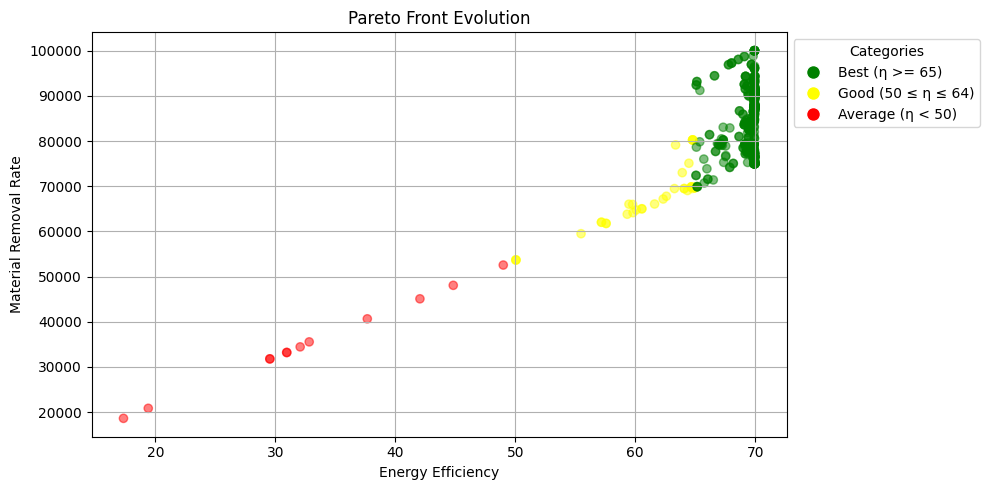

Best Overall Solution:
Energy Efficiency (η): 69.97667274818707
Material Removal Rate (MRR): 89993.46340842487
Average Temperature (Tavg): 80.0
Tool Wear Rate (Tw): 18.63457652820762
Vibration Amplitude (Av): 10.0
Inputs for Best Overall Solution:
Spindle Speed (rpm): 1799.8692681684972
Feed Rate (mm/rev): 50.0
Cooling Rate (L/min): 1
Cutting Speed (m/min): 284.7479710732467
Mass (kg): 50.20983833131868
+-----------------------+-------------------+----------+
|        Metric         |       Value       | Category |
+-----------------------+-------------------+----------+
|   Energy Efficiency   | 69.97667274818707 |   Good   |
| Material Removal Rate | 89993.46340842487 |   Good   |
|  Average Temperature  |       80.0        |   Best   |
|    Tool Wear Rate     | 18.63457652820762 |   Best   |
|  Vibration Amplitude  |       10.0        |   Best   |
+-----------------------+-------------------+----------+


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools
from tabulate import tabulate


creator.create("FitnessMax", base.Fitness, weights=(1.0, 1.0, 1.0, 1.0, 1.0))
creator.create("Individual", list, fitness=creator.FitnessMax)

NGEN = 50
POP_SIZE = 100
MUT_PB = 0.2
CX_PB = 0.5
MUT_SD = 0.1
nobj = 5

def evaluate(individual):
    spindle_speed, feed_rate, cooling_rate, cutting_speed, mass = individual
    spindle_speed = max(min(spindle_speed, 2000), 1500)
    cooling_rate = max(min(cooling_rate, 5), 1)
    feed_rate = max(min(feed_rate, 50), 10)
    cutting_speed = max(min(cutting_speed, 400), 200)
    mass = max(min(mass, 60), 30)

    Pinput = spindle_speed * 0.5 + cooling_rate * 0.3
    Puseful = spindle_speed * feed_rate * 0.7
    fitness1 = Puseful / Pinput if Pinput > 0 else 0

    cutting_speed_effective = spindle_speed * 0.1
    depth_of_cut = 2
    width_of_cut = 5
    MRR = cutting_speed_effective * feed_rate * depth_of_cut * width_of_cut
    fitness2 = max(MRR, 0)

    ambient_temp = 25
    thermal_resistance = 0.15
    Pinput = min(Pinput, (80 - ambient_temp) * thermal_resistance / 0.85)
    heat_generated = Pinput * 0.85
    Tavg = ambient_temp + (heat_generated / thermal_resistance)
    fitness3 = min(max(Tavg, 0), 100)

    C = 250
    n = 0.5
    if cutting_speed_effective > 0:
        Tw = C / (cutting_speed_effective ** n)
        fitness4 = min(max(Tw, 0), 100)
    else:
        fitness4 = 100

    Fm = 100
    k = 1000
    w = 2 * 3.14159 * spindle_speed / 60
    if (k - mass * (w**2)) > 0:
        Av = Fm / (k - mass * (w**2)) + random.uniform(0.1, 0.5)
        fitness5 = min(max(Av, 0), 10)
    else:
        fitness5 = 10

    return fitness1, fitness2, fitness3, fitness4, fitness5

def categorize(value, metric):
    if metric == "Energy Efficiency":
        if value >= 75:
            return "Best"
        elif value >= 50:
            return "Good"
        else:
            return "Average"
    elif metric == "Material Removal Rate":
        if value >= 100000:
            return "Best"
        elif value >= 50000:
            return "Good"
        else:
            return "Average"
    elif metric == "Average Temperature":
        if value <= 100:
            return "Best"
        elif value <= 200:
            return "Good"
        else:
            return "Average"
    elif metric == "Tool Wear Rate":
        if value <= 100:
            return "Best"
        elif value <= 150:
            return "Good"
        else:
            return "Average"
    elif metric == "Vibration Amplitude":
        if value <= 10:
            return "Best"
        elif value <= 15:
            return "Good"
        else:
            return "Average"

def repair(individual):
    individual[0] = max(min(individual[0], 2000), 1500)
    individual[1] = max(min(individual[1], 50), 10)
    individual[2] = max(min(individual[2], 5), 1)
    individual[3] = max(min(individual[3], 400), 200)
    individual[4] = max(min(individual[4], 60), 30)
    return individual,

def main():
    toolbox = base.Toolbox()
    toolbox.register("spindle_speed", random.uniform, 1500, 2000)
    toolbox.register("feed_rate", random.uniform, 10, 50)
    toolbox.register("cooling_rate", random.uniform, 1, 5)
    toolbox.register("cutting_speed", random.uniform, 200, 400)
    toolbox.register("mass", random.uniform, 30, 60)
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.spindle_speed, toolbox.feed_rate, toolbox.cooling_rate, toolbox.cutting_speed, toolbox.mass), n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=MUT_SD, indpb=0.2)
    toolbox.register("select", tools.selNSGA2)

    population = toolbox.population(n=POP_SIZE)
    best_overall_solution = None
    pareto_front_history = []

    for gen in range(NGEN):
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CX_PB:
                toolbox.mate(child1, child2)
                repair(child1)
                repair(child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUT_PB:
                toolbox.mutate(mutant)
                repair(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        population[:] = offspring

        pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]
        pareto_front_history.append(pareto_front)

        if population:
            try:
                best_solution = max(population, key=lambda x: x.fitness.values[0])
                if best_overall_solution is None or best_solution.fitness.values[0] > best_overall_solution.fitness.values[0]:
                    best_overall_solution = best_solution
            except IndexError:
                print("Error accessing fitness values. Check if individuals have valid fitness values.")

    plt.figure(figsize=(10, 5))

    for front in pareto_front_history:
        fitness_values = [ind.fitness.values for ind in front]
        colors = []
        for fit in fitness_values:
            if fit[0] > 65:
                colors.append('green')
            elif 50 <= fit[0] <= 65:
                colors.append('yellow')
            else:
                colors.append('red')
        plt.scatter([fit[0] for fit in fitness_values], [fit[1] for fit in fitness_values],
                    alpha=0.5, c=colors)

    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Best (η >= 65)', markerfacecolor='green', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Good (50 ≤ η ≤ 64)', markerfacecolor='yellow', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Average (η < 50)', markerfacecolor='red', markersize=10),
    ]

    plt.legend(handles=handles, title='Categories', loc='upper left', bbox_to_anchor=(1, 1))
    plt.title("Pareto Front Evolution")
    plt.xlabel("Energy Efficiency")
    plt.ylabel("Material Removal Rate")
    plt.grid()
    plt.tight_layout()
    plt.show()

    print("Best Overall Solution:")
    print(f"Energy Efficiency (η): {best_overall_solution.fitness.values[0]}")
    print(f"Material Removal Rate (MRR): {best_overall_solution.fitness.values[1]}")
    print(f"Average Temperature (Tavg): {best_overall_solution.fitness.values[2]}")
    print(f"Tool Wear Rate (Tw): {best_overall_solution.fitness.values[3]}")
    print(f"Vibration Amplitude (Av): {best_overall_solution.fitness.values[4]}")
    print("Inputs for Best Overall Solution:")
    print(f"Spindle Speed (rpm): {best_overall_solution[0]}")
    print(f"Feed Rate (mm/rev): {best_overall_solution[1]}")
    print(f"Cooling Rate (L/min): {best_overall_solution[2]}")
    print(f"Cutting Speed (m/min): {best_overall_solution[3]}")
    print(f"Mass (kg): {best_overall_solution[4]}")

    metrics = [
        ("Energy Efficiency", best_overall_solution.fitness.values[0], categorize(best_overall_solution.fitness.values[0], "Energy Efficiency")),
        ("Material Removal Rate", best_overall_solution.fitness.values[1], categorize(best_overall_solution.fitness.values[1], "Material Removal Rate")),
        ("Average Temperature", best_overall_solution.fitness.values[2], categorize(best_overall_solution.fitness.values[2], "Average Temperature")),
        ("Tool Wear Rate", best_overall_solution.fitness.values[3], categorize(best_overall_solution.fitness.values[3], "Tool Wear Rate")),
        ("Vibration Amplitude", best_overall_solution.fitness.values[4], categorize(best_overall_solution.fitness.values[4], "Vibration Amplitude")),
    ]

    print(tabulate(metrics, headers=["Metric", "Value", "Category"], tablefmt="pretty"))

if __name__ == "__main__":
    main()


In [ ]:
!pip install deap matplotlib tabulate